# BEST (vs. null hypothesis significance testing)

In [1]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/home/tommy/ml_drought


In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import matplotlib as mpl
from tqdm import tqdm
from collections import defaultdict

mpl.rcParams['figure.dpi'] = 150

In [3]:
# data_dir = Path('data/')
data_dir = Path('/cats/datastore/data/')

assert data_dir.exists()

In [9]:
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data
from src.analysis.evaluation import join_true_pred_da
from src.models import load_model

# Read in the CAMELS data

In [10]:
# read in the training data
ds = xr.open_dataset(data_dir / "RUNOFF/ALL_dynamic_ds.nc")
ds['station_id'] = ds['station_id'].astype(int)

all_static = xr.open_dataset(data_dir / f'RUNOFF/interim/static/data.nc')
all_static['station_id'] = all_static['station_id'].astype(int)
static = all_static

# Read AWS Trained Models

In [11]:
# ealstm_less_vars = pd.read_csv(data_dir / "runs/ealstm_less_vars_2004_1707_1424/results_ealstm_less_vars_2004_1707_1424_E015.csv")
# ealstm_preds = xr.open_dataset(data_dir / "runs/ensemble/data_ENS.csv")
ealstm_ensemble_df = pd.read_csv(data_dir / "runs/ensemble_EALSTM/data_ENS.csv").drop("Unnamed: 0", axis=1)
ealstm_ensemble_df["time"] = pd.to_datetime(ealstm_ensemble_df["time"])
ealstm_preds = ealstm_ensemble_df.set_index(["station_id", "time"]).to_xarray()

ealstm_preds["station_id"] = [int(sid) for sid in ealstm_preds["station_id"]]

In [12]:
lstm_ensemble_df = pd.read_csv("/cats/datastore/data/runs/ensemble/data_ENS.csv").drop("Unnamed: 0", axis=1)
lstm_ensemble_df["time"] = pd.to_datetime(lstm_ensemble_df["time"])
lstm_ensemble = lstm_ensemble_df.set_index(["station_id", "time"]).to_xarray()
lstm_preds = lstm_ensemble

In [13]:
metric_df = pd.read_csv(data_dir / "runs/ensemble/metric_df.csv", index_col=0)
metric_df.columns = [c.lower() for c in metric_df.columns]
metric_df.head()

station_id       nse       kge       mse        fhv        fms        flv
0       10002  0.898328  0.857653  0.229347 -10.042169  20.175607   4.281218
1       10003  0.926555  0.881110  0.111980  -6.074578   1.342742  28.237229
2        1001  0.876090  0.920412  0.509755   3.647934 -23.746845  70.234474
3      101002  0.757246  0.647206  0.300506 -25.176707  -4.734227  73.409471
4      101005  0.824926  0.796430  0.208704 -18.346511   1.971726  45.197245

# FUSE Data

In [14]:
all_paths = [d for d in (data_dir / "RUNOFF/FUSE/Timeseries_SimQ_Best/").glob("*_Best_Qsim.txt")]

if not (data_dir / "RUNOFF/ALL_fuse_ds.nc").exists():
    all_dfs = []
    for txt in tqdm(all_paths):
        df = pd.read_csv(txt, skiprows=3, header=0)
        df.columns = [c.rstrip().lstrip() for c in df.columns]
        df = df.rename(columns={"YYYY": "year", "MM": "month", "DD": "day"})
        df["time"] = pd.to_datetime(df[["year", "month", "day"]])
        station_id = int(str(txt).split("/")[-1].split("_")[0])
        df["station_id"] = [station_id for _ in range(len(df))]
        df = df.drop(["year", "month", "day", "HH"], axis=1).set_index(["station_id", "time"])
        all_dfs.append(df)
        
    fuse_ds = pd.concat(all_dfs).to_xarray()
    fuse_ds.to_netcdf(data_dir / "RUNOFF/ALL_fuse_ds.nc")
    
else:
    fuse_ds = xr.open_dataset(data_dir / "RUNOFF/ALL_fuse_ds.nc")

In [15]:
fuse_ds = fuse_ds.sel(time=slice('1998-01-01', '2009-01-01'))

In [16]:
# join with observations for stations that exist
obs = (
    ds.sel(station_id=np.isin(ds["station_id"], fuse_ds["station_id"]), time=fuse_ds["time"])["discharge_spec"]
).rename("obs")
fuse_data = fuse_ds.sel(station_id=obs.station_id).merge(obs)

In [17]:
fuse_data

<xarray.Dataset>
Dimensions:          (station_id: 519, time: 4018)
Coordinates:
  * station_id       (station_id) int64 1001 2001 2002 ... 101005 102001 106001
  * time             (time) datetime64[ns] 1998-01-01 1998-01-02 ... 2008-12-31
Data variables:
    SimQ_TOPMODEL    (station_id, time) float64 ...
    SimQ_ARNOVIC     (station_id, time) float64 ...
    SimQ_PRMS        (station_id, time) float64 ...
    SimQ_SACRAMENTO  (station_id, time) float64 ...
    obs              (time, station_id) float64 ...

# Match Stations / Times

In [18]:
all_stations_lstm = np.isin(lstm_preds.station_id, fuse_data.station_id)
all_stations_ealstm = np.isin(ealstm_preds.station_id, fuse_data.station_id)

In [19]:
# lstm_preds = lstm_preds.sel(station_id=all_stations_lstm, time=fuse_data.time)
# ealstm_preds = ealstm_preds.sel(station_id=all_stations_ealstm, time=fuse_data.time)

# Errors

In [23]:
from scripts.drafts.calculate_error_scores import calculate_errors, error_func

In [24]:
ealstm_errors_fp = data_dir / "RUNOFF/0_ealstm_errors.pkl"
lstm_errors_fp = data_dir / "RUNOFF/0_lstm_errors.pkl"

if not (ealstm_errors_fp).exists() or not (lstm_errors_fp).exists():
    ealstm_df = calculate_errors(ealstm_preds).set_index("station_id")
    lstm_df = calculate_errors(lstm_preds).set_index("station_id")



In [25]:
metric_df["rmse"] = np.sqrt(metric_df["mse"])
lstm_df["rmse"] = np.sqrt(lstm_df["mse"])
ealstm_df["rmse"] = np.sqrt(ealstm_df["mse"])

display(metric_df.set_index("station_id").sort_index().head())
display(lstm_df.sort_index().head())

nse       kge       mse        fhv        fms        flv  \
station_id                                                                  
1001        0.876090  0.920412  0.509755   3.647934 -23.746845  70.234474   
2001        0.796159  0.737755  1.295476 -23.338750  -8.885240   8.945649   
2002        0.799168  0.721571  2.248968 -26.614591 -20.047770  54.950795   
3003        0.878744  0.851921  4.253649 -13.508330 -20.236829  54.121467   
4001        0.872644  0.860455  1.789749  -4.687964 -18.653824  39.811433   

                rmse  
station_id            
1001        0.713971  
2001        1.138190  
2002        1.499656  
3003        2.062438  
4001        1.337815

nse       kge       mse       bias   log_nse   inv_kge  \
station_id                                                                
1001        0.876090  0.920412  0.509755   4.266320  0.785360  0.920412   
2001        0.796159  0.737755  1.295476 -12.189085  0.885491  0.737755   
2002        0.799168  0.721571  2.248968  -7.375567  0.846839  0.721571   
3003        0.878744  0.851921  4.253648  -0.086631  0.875849  0.851921   
4001        0.872644  0.860455  1.789749  -3.644160  0.801445  0.860455   

                rmse  
station_id            
1001        0.713971  
2001        1.138190  
2002        1.499656  
3003        2.062437  
4001        1.337815

In [26]:
ealstm_nse = ealstm_df["nse"]
lstm_nse = lstm_df["nse"]

# ealstm_nse['negative'] = ealstm_nse['nse'] < 0
# lstm_nse['negative'] = lstm_nse['nse'] < 0

# FUSE - Calculate from Sim

In [27]:
from scripts.drafts.calculate_error_scores import FuseErrors

In [29]:
fuse_errors_fp = data_dir / "RUNOFF/0_fuse_errors.pkl"
fuse_class_fp = data_dir / "RUNOFF/0_fuse_class.pkl"

if not (fuse_errors_fp).exists() or not (fuse_class_fp).exists():
    f_class = FuseErrors(fuse_data)
    fuse_errors = f_class.fuse_errors
    
    pickle.dump(f_class, fuse_class_fp.open("wb"))
    pickle.dump(fuse_errors, fuse_errors_fp.open("wb"))
else:
    f_class = pickle.load(fuse_class_fp.open("rb"))
    fuse_errors = pickle.load(fuse_errors_fp.open("rb"))

In [30]:
fuse_bias = f_class.get_metric_df("bias")
fuse_nse_df = f_class.get_metric_df("nse")
fuse_kge_df = f_class.get_metric_df("kge")
# fuse_kge_df.head()

In [31]:
nse_df = fuse_nse_df.join(lstm_nse.rename("LSTM")).join(ealstm_nse.rename("EALSTM"))

In [35]:
nse = nse_df
nse = nse.reset_index()
nse = nse.melt(id_vars=["index", "Name"]).rename({"value": "nse", "variable": "model"}, axis=1)
nse["group"] = pd.Categorical(nse["model"]).codes
nse.head()

index                     Name model       nse  group
0   1001          Wick at Tarroul  PRMS  0.786218      2
1   2001   Helmsdale at Kilphedir  PRMS  0.686722      2
2   2002     Brora at Bruachrobie  PRMS  0.683937      2
3   3003  Oykel at Easter Turnaig  PRMS  0.793153      2
4   4001      Conon at Moy Bridge  PRMS  0.777022      2

# BEST

In [34]:
import pystan
import arviz

In [39]:
from sklearn.preprocessing import OneHotEncoder

In [92]:
def get_comparison(
    df: pd.DataFrame, 
    reference_model: str = "TOPMODEL", 
    comparison_model: str = "LSTM", 
    one_hot_encode: bool = True,
):
    assert "model" in df.columns
    assert all(np.isin([reference_model, comparison_model], df["model"].unique()))

    # select only those models from the data
    df = df.loc[(df["model"] == reference_model) | (df["model"] == comparison_model)].reset_index()

    # Create design matrix as OHE features
    if one_hot_encode:
        ohe = OneHotEncoder(sparse=False)
        X = pd.DataFrame(
            ohe.fit_transform(df["model"].values.reshape(-1, 1)),
            columns=[fn.replace("x0_", "") for fn in ohe.get_feature_names()]
        )
        X = X[[reference_model, comparison_model]]

    # Create design matrix as long feature
    else:
        # encode group as zero, one
        df.loc[df["model"] == reference_model, "group"] = 0
        df.loc[df["model"] == comparison_model, "group"] = 1

        X = df[["group"]]

    return df[["index", "nse"]].join(X)

In [300]:
# https://bookdown.org/content/3686/metric-predicted-variable-on-one-or-two-groups.html#two-groups
# raw output from brms: `bf(nse ~ 0 + model, sigma ~ 0 + model)`
model_code = """
// generated with brms 2.13.5
functions {
  /* compute the logm1 link 
   * Args: 
   *   p: a positive scalar
   * Returns: 
   *   a scalar in (-Inf, Inf)
   */ 
   real logm1(real y) { 
     return log(y - 1);
   }
  /* compute the inverse of the logm1 link 
   * Args: 
   *   y: a scalar in (-Inf, Inf)
   * Returns: 
   *   a positive scalar
   */ 
   real expp1(real y) { 
     return exp(y) + 1;
   }
}
data {
  int<lower=1> N;  // number of observations
  vector[N] Y;  // response variable
  int<lower=1> K;  // number of population-level effects
  matrix[N, K] X;  // population-level design matrix
  int<lower=1> K_sigma;  // number of population-level effects
  matrix[N, K_sigma] X_sigma;  // population-level design matrix
  int prior_only;  // should the likelihood be ignored?
}
transformed data {
}
parameters {
  vector[K] b;  // population-level effects
  vector[K_sigma] b_sigma;  // population-level effects
  real<lower=1> nu;  // degrees of freedom or shape
}
transformed parameters {
}
model {
  // initialize linear predictor term
  vector[N] mu = X * b;
  // initialize linear predictor term
  vector[N] sigma = X_sigma * b_sigma;
  for (n in 1:N) {
    // apply the inverse link function
    sigma[n] = exp(sigma[n]);
  }
  // priors including all constants
  target += gamma_lpdf(nu | 2, 0.1)
    - 1 * gamma_lccdf(1 | 2, 0.1);
  // likelihood including all constants
  if (!prior_only) {
    target += student_t_lpdf(Y | nu, mu, sigma);
  }
}
generated quantities {
}

"""

In [301]:
brms_model = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_51be59e5643f7babfb9b5c6df103f2ac NOW.


In [148]:
df = get_comparison(nse, reference_model="TOPMODEL", comparison_model="LSTM", one_hot_encode=True)
df.head()

index       nse  TOPMODEL  LSTM
0   1001  0.754303       1.0   0.0
1   2001  0.655162       1.0   0.0
2   2002  0.691850       1.0   0.0
3   3003  0.806642       1.0   0.0
4   4001  0.724438       1.0   0.0

In [302]:
df = get_comparison(nse, reference_model="TOPMODEL", comparison_model="LSTM", one_hot_encode=True)
df = df.dropna()
data = dict(
    N=len(df),                     # size of dataframe
    Y=df["nse"].values,            # target variable (NSE)
    K=2,                           # number of groups
    X=df.iloc[:, 2:].values,       # design matrix (ohe group)
    K_sigma=2,                     # number of groups
    X_sigma=df.iloc[:, 2:].values, # design matrix (ohe group)
    prior_only=0                   # prior predictive check?
)
# make sure there are no nans in data
assert not all(np.array([np.isnan(v) for v in data.values()]))

In [303]:
fit = brms_model.sampling(data=data, iter=1000, chains=4)
fit

Inference for Stan model: anon_model_51be59e5643f7babfb9b5c6df103f2ac.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b[1]         0.76  1.1e-4 4.8e-3   0.75   0.76   0.76   0.77   0.77   2088    1.0
b[2]         0.88  4.6e-5 2.2e-3   0.88   0.88   0.88   0.88   0.89   2288    1.0
b_sigma[1]  -2.53  1.7e-3   0.06  -2.64  -2.57  -2.53  -2.49  -2.42   1023    1.0
b_sigma[2]  -3.16  1.5e-3   0.05  -3.25  -3.19  -3.16  -3.12  -3.06   1007    1.0
nu           2.08  5.2e-3   0.16    1.8   1.97   2.07   2.18   2.41    916   1.01
lp__       1108.7    0.05   1.57 1104.8 1107.9 1109.0 1109.9 1110.8    932    1.0

Samples were drawn using NUTS at Wed Nov 11 18:04:36 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [366]:
# prior_data = data
# prior_data["prior_only"] = 1
# prior_fit = brms_model.sampling(prior_data, iter=1000, chains=4)
# prior_fit

In [178]:
# print(dir(arviz))
sample = arviz.from_pystan(
    posterior=fit, 
    dims={"b": ["model"], "b_sigma": ["model"]}, 
    coords={"model": ["TOPMODEL", "LSTM"]}
)
post = sample.posterior.stack(sample=["chain", "draw"])
post

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 500, model: 2)
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
  * model    (model) <U8 'TOPMODEL' 'LSTM'
Data variables:
    b        (chain, draw, model) float64 0.7689 0.8826 0.7663 ... 0.7677 0.8827
    b_sigma  (chain, draw, model) float64 -2.601 -3.263 -2.526 ... -2.45 -3.124
    nu       (chain, draw) float64 1.884 1.885 2.107 2.325 ... 2.152 2.041 2.346
Attributes:
    created_at:                 2020-11-11T15:19:53.866693
    arviz_version:              0.10.0
    inference_library:          pystan
    inference_library_version:  2.19.1.1
    args:                       [{'random_seed': '861483642', 'chain_id': 0, ...
    inits:                      [[-1.9498149620760636, -0.25853482179064047, ...
    step_size:                  [0.453394, 0.420003, 0.369285, 0.35087]
    metric:                     ['diag_e', 'diag_e', 'diag_e', 'diag_e']
    inv_metric:                 [[4.37034e-05, 2.81674e-05, 0.00343626, 0.002...
    adaptation_info:            ['# Adaptation terminated\n# Step size = 0.45...
    stan_code:                  \n// generated with brms 2.13.5\nfunctions {\...

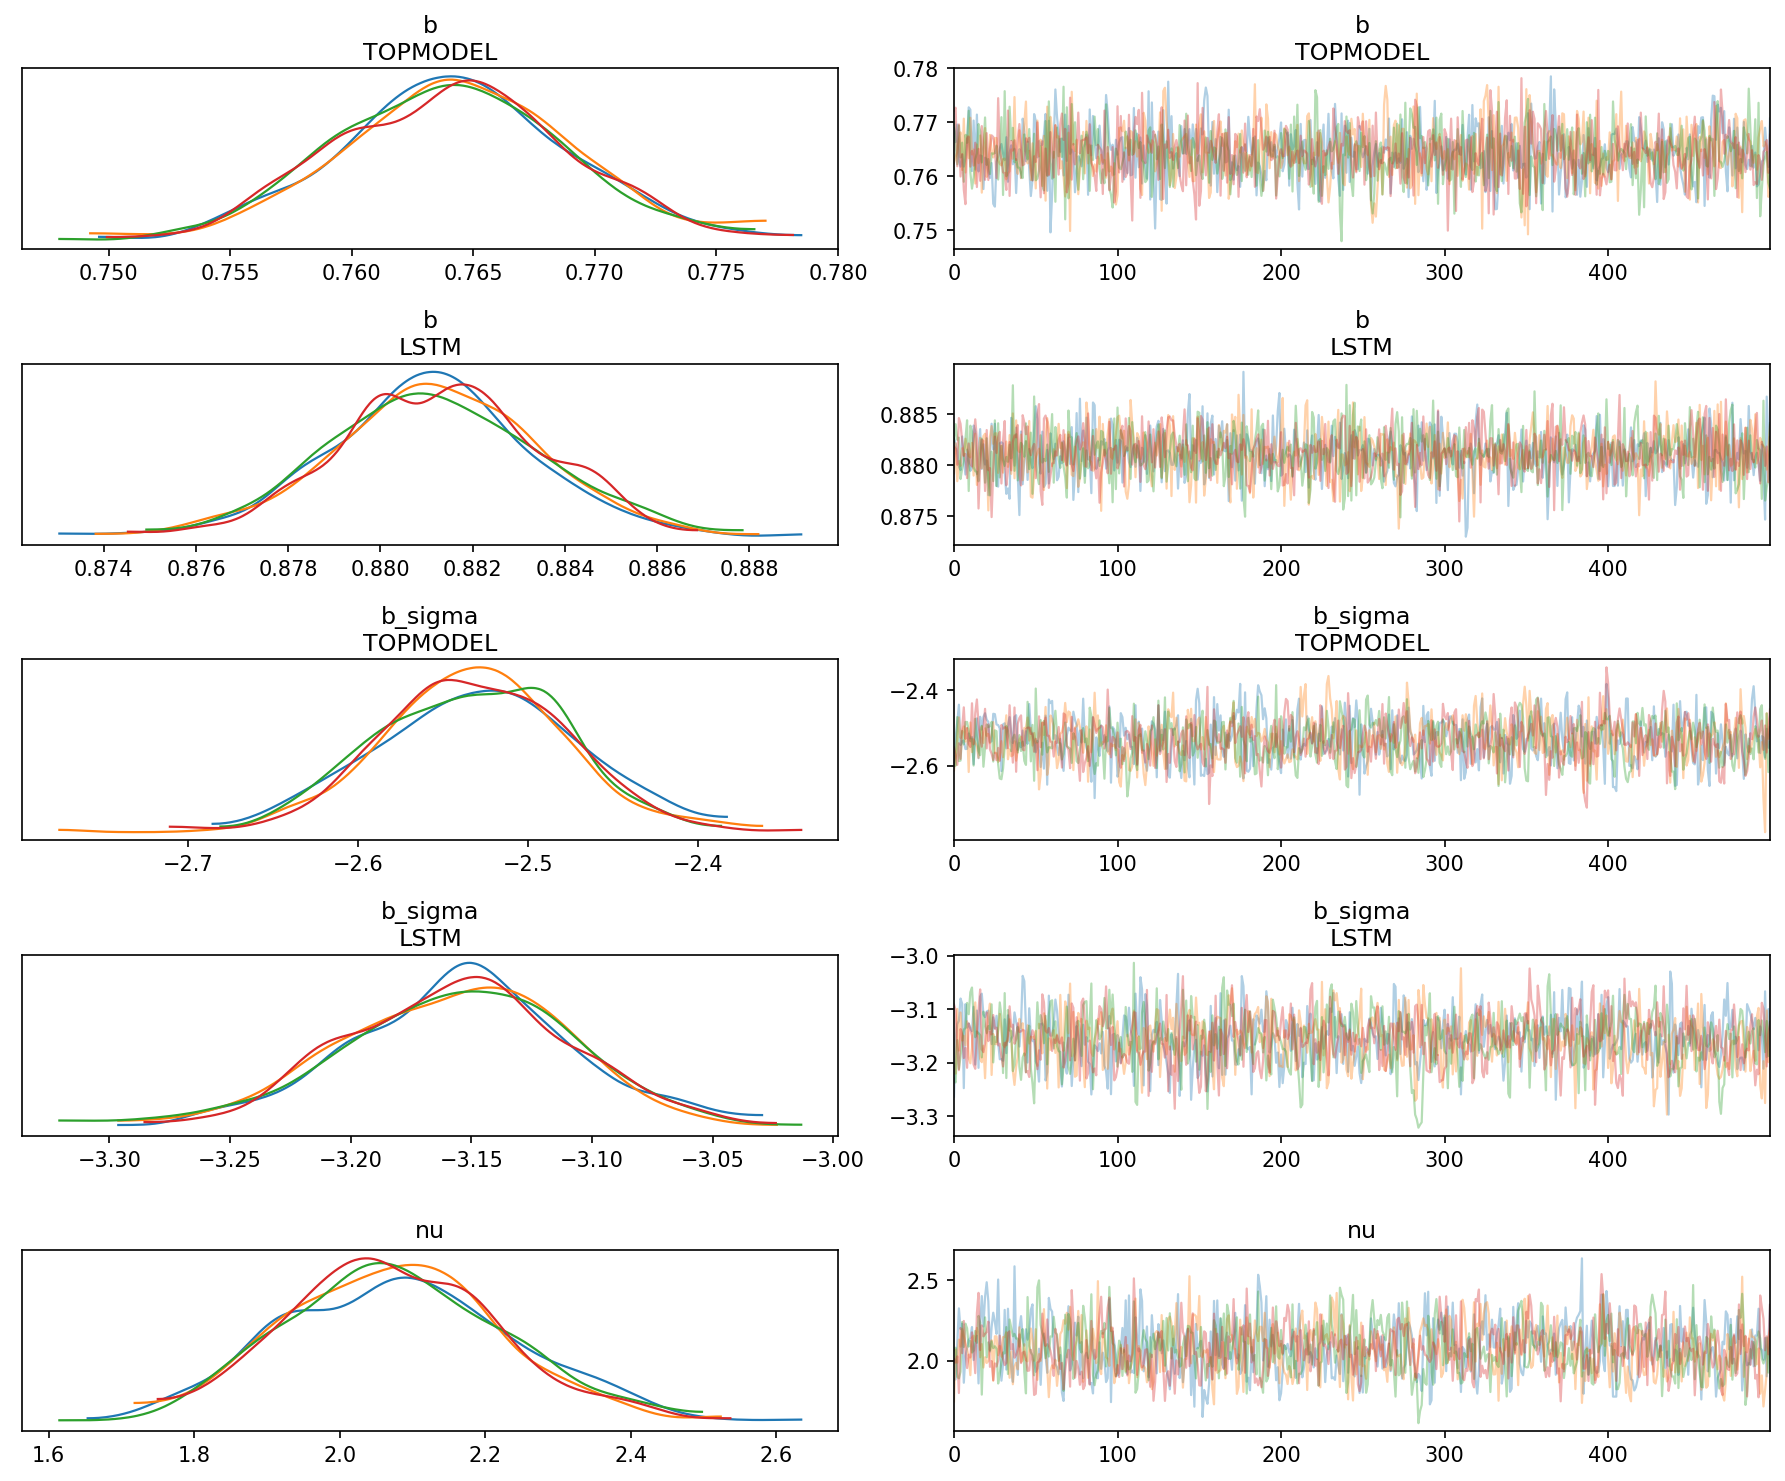

In [179]:
arviz.plot_trace(sample)
plt.tight_layout()

In [367]:
from scipy.stats import t
from typing import Tuple


def get_t_dist_params(
    posterior: xr.Dataset, 
    model: str,
    nu_param: str = "nu",
    mu_param: str = "b",
    sigma_param: str = "b_sigma",
    exp_sigma: bool = True,
) -> Tuple[float]:
    nu = np.log10(posterior[nu_param].values)
    mu = posterior[mu_param].sel(model=model).values
    sigma = posterior[sigma_param].sel(model=model).values
    if exp_sigma:
        sigma = np.exp(sigma)
    
    return nu, mu, sigma

def plot_sample_of_t_distributions(
    post: xr.Dataset, 
    N: int = 100,
    nu_param: str = "nu",
    mu_param: str = "b",
    sigma_param: str = "b_sigma",
    exp_sigma: bool = True,
    ax=None,
    xlim: Tuple[float] = (-1, 1),
):

    if ax is None:
        f, ax = plt.subplots()

    x = np.linspace(xlim[0], xlim[-1], 100)

    colors = sns.color_palette()
    for ix, model in enumerate(post["model"].values):
        # get median
        median = post.median(dim="sample")
        params = get_t_dist_params(median, model, nu_param, mu_param, sigma_param, exp_sigma=exp_sigma)
        ax.plot(x, [t.pdf(v, *params) for v in x], label=model, alpha=1, color=colors[ix])

        # get random samples
        samples = np.random.choice(post.sample.values, N)
        for samp in tqdm(samples, desc=f"Plotting {model}"):
            p = post.sel(sample=samp)
            params = get_t_dist_params(p, model, nu_param, mu_param, sigma_param, exp_sigma=exp_sigma)
            ax.plot(x, [t.pdf(v, *params) for v in x], alpha=0.1, color=colors[ix])

        ax.legend()

    ax.set_title(f"{N} randomly sampled T Distributions")
    ax.set_xlabel("NSE")
    ax.set_yticklabels([])
    ax.set_yticks([])
    sns.despine()
    return ax

Plotting LSTM: 100%|██████████| 100/100 [00:02<00:00, 44.57it/s]


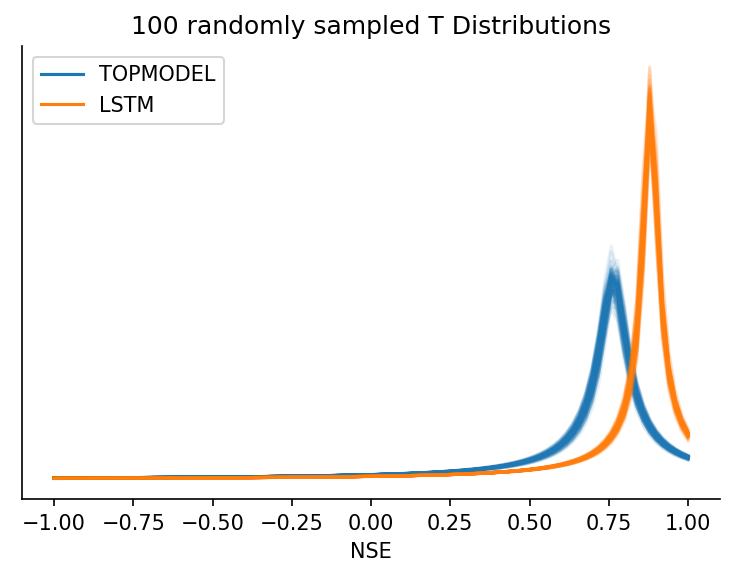

In [368]:
plot_sample_of_t_distributions(post, N=100);

## Check the priors

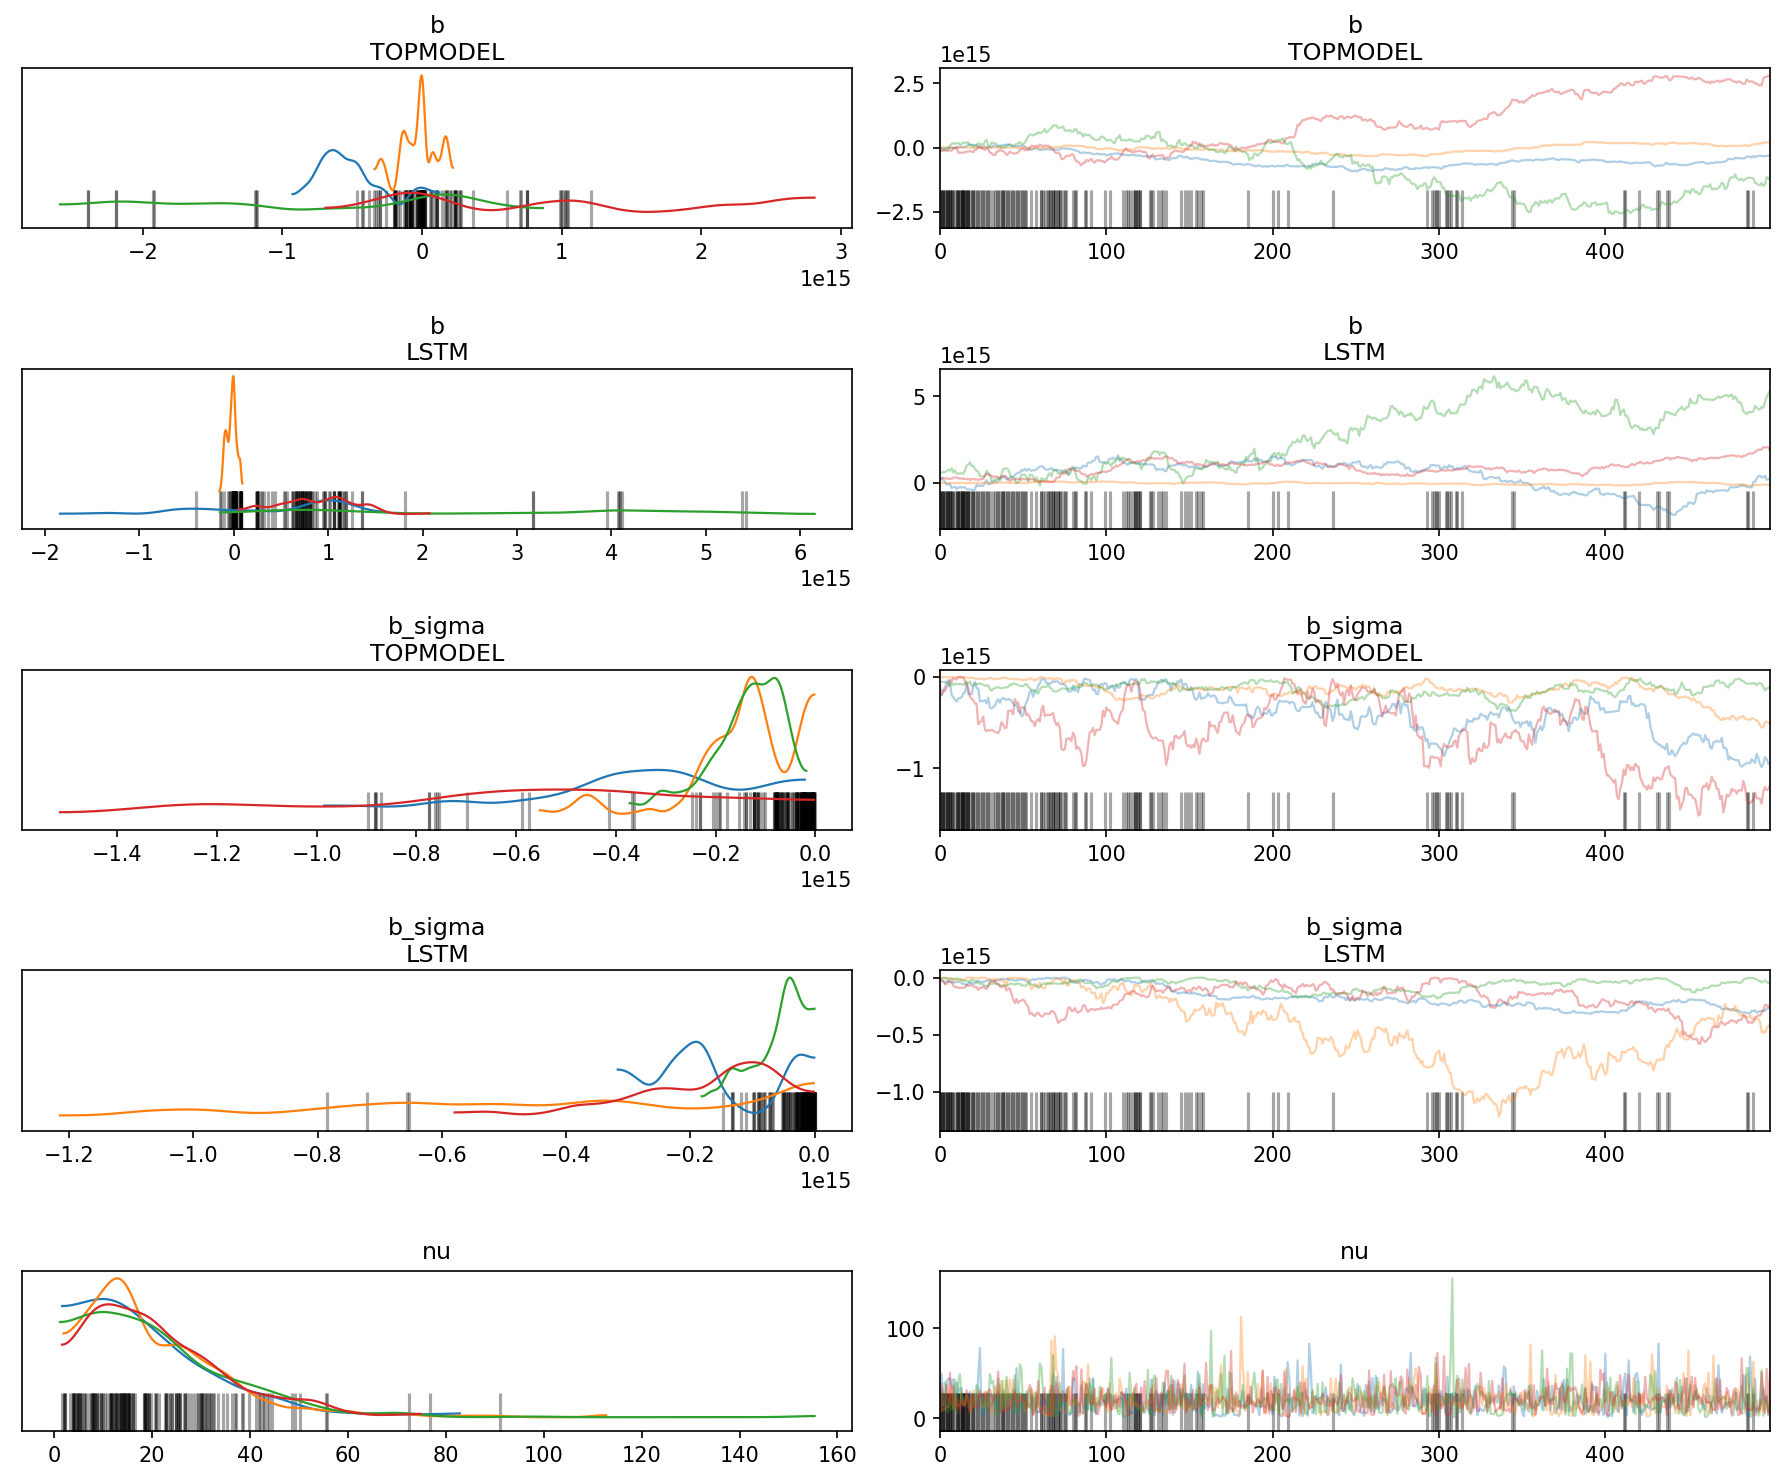

In [308]:
prior = arviz.from_pystan(
    posterior=prior_fit, 
    dims={"b": ["model"], "b_sigma": ["model"]}, 
    coords={"model": ["TOPMODEL", "LSTM"]}
)
prior_xr = prior.posterior.stack(sample=["chain", "draw"])
arviz.plot_trace(prior)
plt.tight_layout()

In [322]:
f, ax = plt.subplots()
# ax = plot_sample_of_t_distributions(prior_xr, N=100, ax=ax)

t.pdf(x, *get_t_dist_params(prior_xr.median(dim="sample"), model="LSTM")) for x in np.arange(-1000, 1000, 100)

SyntaxError: invalid syntax (<ipython-input-322-17226a88e730>, line 4)

(1.2357592327045572, array(6.99506336e+14), 0.0)

# Fit Other model

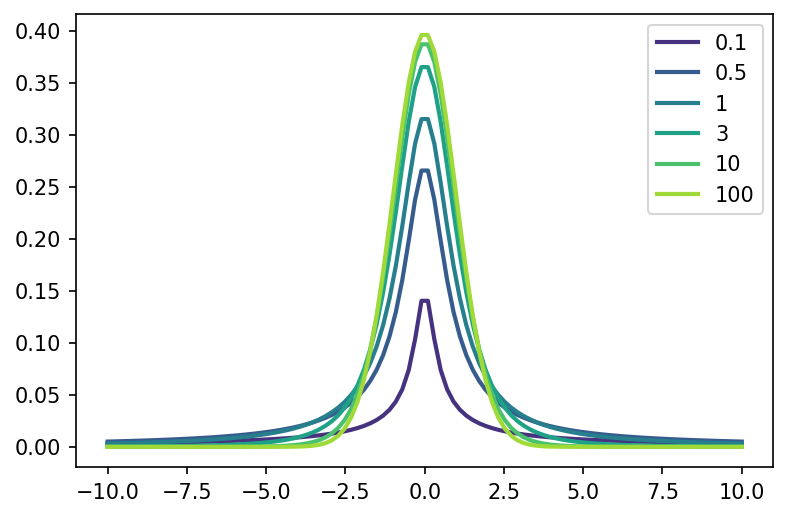

In [343]:
from scipy.stats import truncnorm, t

# priors
f, ax = plt.subplots()
x = np.linspace(-10, 10, 100)
colors = sns.color_palette("viridis")
for ix, val in enumerate([0.1, 0.5, 1, 3, 10, 100]):
    rv = t(val)
    ax.plot(x, rv.pdf(x), color=colors[ix], lw=2, label=val)
ax.legend()

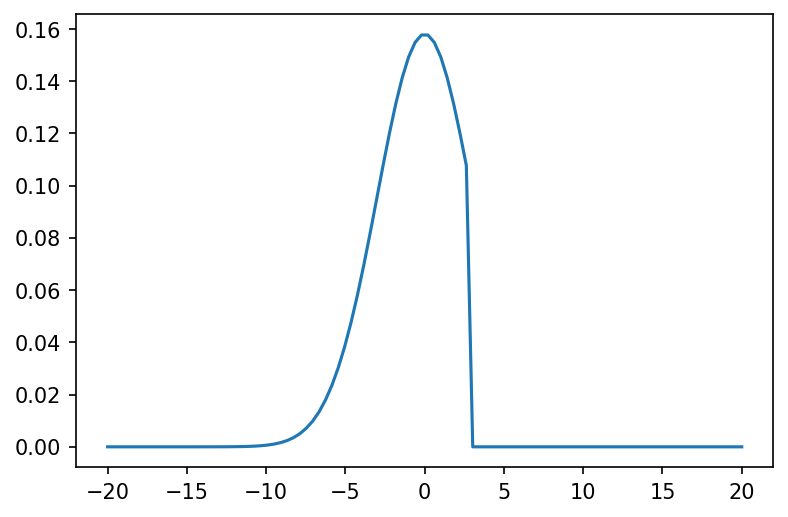

In [351]:
f, ax = plt.subplots()
x = np.linspace(-20, 20, 100)

ax.plot(x, truncnorm(-np.inf, 1, loc=0, scale=3).pdf(x))

In [354]:
# http://127.0.0.1:30671/library/brms/doc/brms_distreg.html

# Other stan file: 
# https://www.andrewheiss.com/blog/2019/01/29/diff-means-half-dozen-ways/
# https://github.com/andrewheiss/diff-means-half-dozen-ways/blob/master/imdb_best.stan
stan_code = """
// Stan implementation of John Kruschke's Bayesian Estimation Supersedes the 
// t-test (BEST), in John K. Kruschke, "Bayesian Estimation Supersedes the t 
// test," *Journal of Experimental Psychology* 142, no. 2 (May 2013): 573–603, 
// doi:10.1037/a0029146.

// Adapted from code by Michael Clark
// https://github.com/m-clark/Miscellaneous-R-Code/blob/master/ModelFitting/Bayesian/rstant_testBEST.R

// Stuff coming in from R
data {
  int<lower=1> N;  // Sample size
  int<lower=2> n_groups;  // Number of groups
  vector<upper=1>[N] y;  // Outcome variable
  int<lower=1, upper=n_groups> group_id[N];  // Group variable
  int prior_only;  // should the likelihood be ignored?

}

// Stuff to transform in Stan
transformed data {
  real mean_y;
  
  mean_y = mean(y); 
}

// Stuff to estimate
parameters {
  vector<upper=1>[2] mu;                 // Estimated group means 
  vector<lower=0.0000001>[2] sigma;      // Estimated group sd
  real<lower=0, upper=100> nu;           // df for t distribution
}

// Models and distributions
model {
  // Priors
  // curve(expr = dnorm(mean_y, 2), from = -5, to = 5)
  mu ~ normal(0, 3);
  
  // curve(expr = dcauchy(x, location = 0, scale = 1), from = 0, to = 40)
  sigma ~ cauchy(0, 1);
  
  // Kruschke uses a nu of exponential(1/29)
  // curve(expr = dexp(x, 1/29), from = 0, to = 200)
  nu ~ exponential(1.0/29);
  
  
  // Likelihood
  if (!prior_only) {
      for (n in 1:N){
        y[n] ~ student_t(nu, mu[group_id[n]], sigma[group_id[n]]);
      }
  }
}

// Stuff to calculate with Stan
generated quantities {
  // Mean difference
  real mu_diff;
  
  // Effect size; see footnote 1 in Kruschke:2013
  // Standardized difference between two means
  // See https://en.wikipedia.org/wiki/Effect_size#Cohen's_d
  real cohen_d;
  
  // Common language effect size
  // The probability that a score sampled at random from one distribution will 
  // be greater than a score sampled from some other distribution
  // See https://janhove.github.io/reporting/2016/11/16/common-language-effect-sizes
  real cles;

  mu_diff = mu[1] - mu[2];
  cohen_d = mu_diff / sqrt(sum(sigma)/2);
  cles = normal_cdf(mu_diff / sqrt(sum(sigma)), 0, 1);
}
"""

In [355]:
other_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_93cdb9e868775dbd11f1c7736b2df23e NOW.


In [356]:
df = get_comparison(nse, reference_model="TOPMODEL", comparison_model="LSTM", one_hot_encode=False)
df = df.dropna()
data = dict(
    N=len(df),
    n_groups=len(df["group"].unique()),
    y=df["nse"],
    group_id=df["group"] + 1,
    prior_only=0
)

In [357]:
other_fit = other_model.sampling(data=data, iter=1000, chains=4)
other_fit

Inference for Stan model: anon_model_93cdb9e868775dbd11f1c7736b2df23e.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[1]      0.76  1.1e-4 4.7e-3   0.75   0.76   0.76   0.77   0.77   1973    1.0
mu[2]      0.88  4.6e-5 2.1e-3   0.88   0.88   0.88   0.88   0.89   2108    1.0
sigma[1]   0.08  1.0e-4 4.5e-3   0.07   0.08   0.08   0.08   0.09   1870    1.0
sigma[2]   0.04  4.8e-5 2.0e-3   0.04   0.04   0.04   0.04   0.05   1853    1.0
nu         2.08  4.0e-3   0.16   1.79   1.96   2.07   2.18    2.4   1529    1.0
mu_diff   -0.12  1.1e-4 5.1e-3  -0.13  -0.12  -0.12  -0.11  -0.11   2066    1.0
cohen_d   -0.47  4.5e-4   0.02  -0.52  -0.49  -0.47  -0.46  -0.43   2160    1.0
cles       0.37  1.2e-4 5.6e-3   0.36   0.37   0.37   0.37   0.38   2160    1.0
lp__     1782.9    0.05   1.54 1779.1 1782.1 1783.2 1784.0 1784.9   1017    1.0

Samples were

In [358]:
prior_data = data
prior_data["prior_only"] = 1
prior_fit = other_model.sampling(data=prior_data, iter=1000, chains=4)
prior_fit

Inference for Stan model: anon_model_93cdb9e868775dbd11f1c7736b2df23e.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[1]      -1.87    0.05   2.01  -6.63  -3.11  -1.56  -0.28   0.82   1579    1.0
mu[2]      -1.86    0.05   1.97  -6.48  -3.07  -1.54  -0.32   0.86   1456    1.0
sigma[1]    5.47    1.29  37.78   0.05   0.42   1.01   2.54   27.3    860    1.0
sigma[2]    5.34    1.29   49.3   0.05   0.43   1.02   2.27  24.39   1452    1.0
nu         26.03    0.66  22.42   0.73   8.29  19.48  37.68   87.1   1168    1.0
mu_diff  -8.9e-3    0.07   2.82  -5.62  -1.89 5.9e-3   1.92   5.51   1606    1.0
cohen_d    -0.04    0.08   3.07  -6.61   -1.5 3.1e-3   1.45   6.31   1577    1.0
cles         0.5  9.4e-3   0.36 1.5e-6   0.14    0.5   0.85    1.0   1422    1.0
lp__       -0.66    0.07   1.88  -5.21  -1.67  -0.32   0.75   1.98    639   1.01

Sa

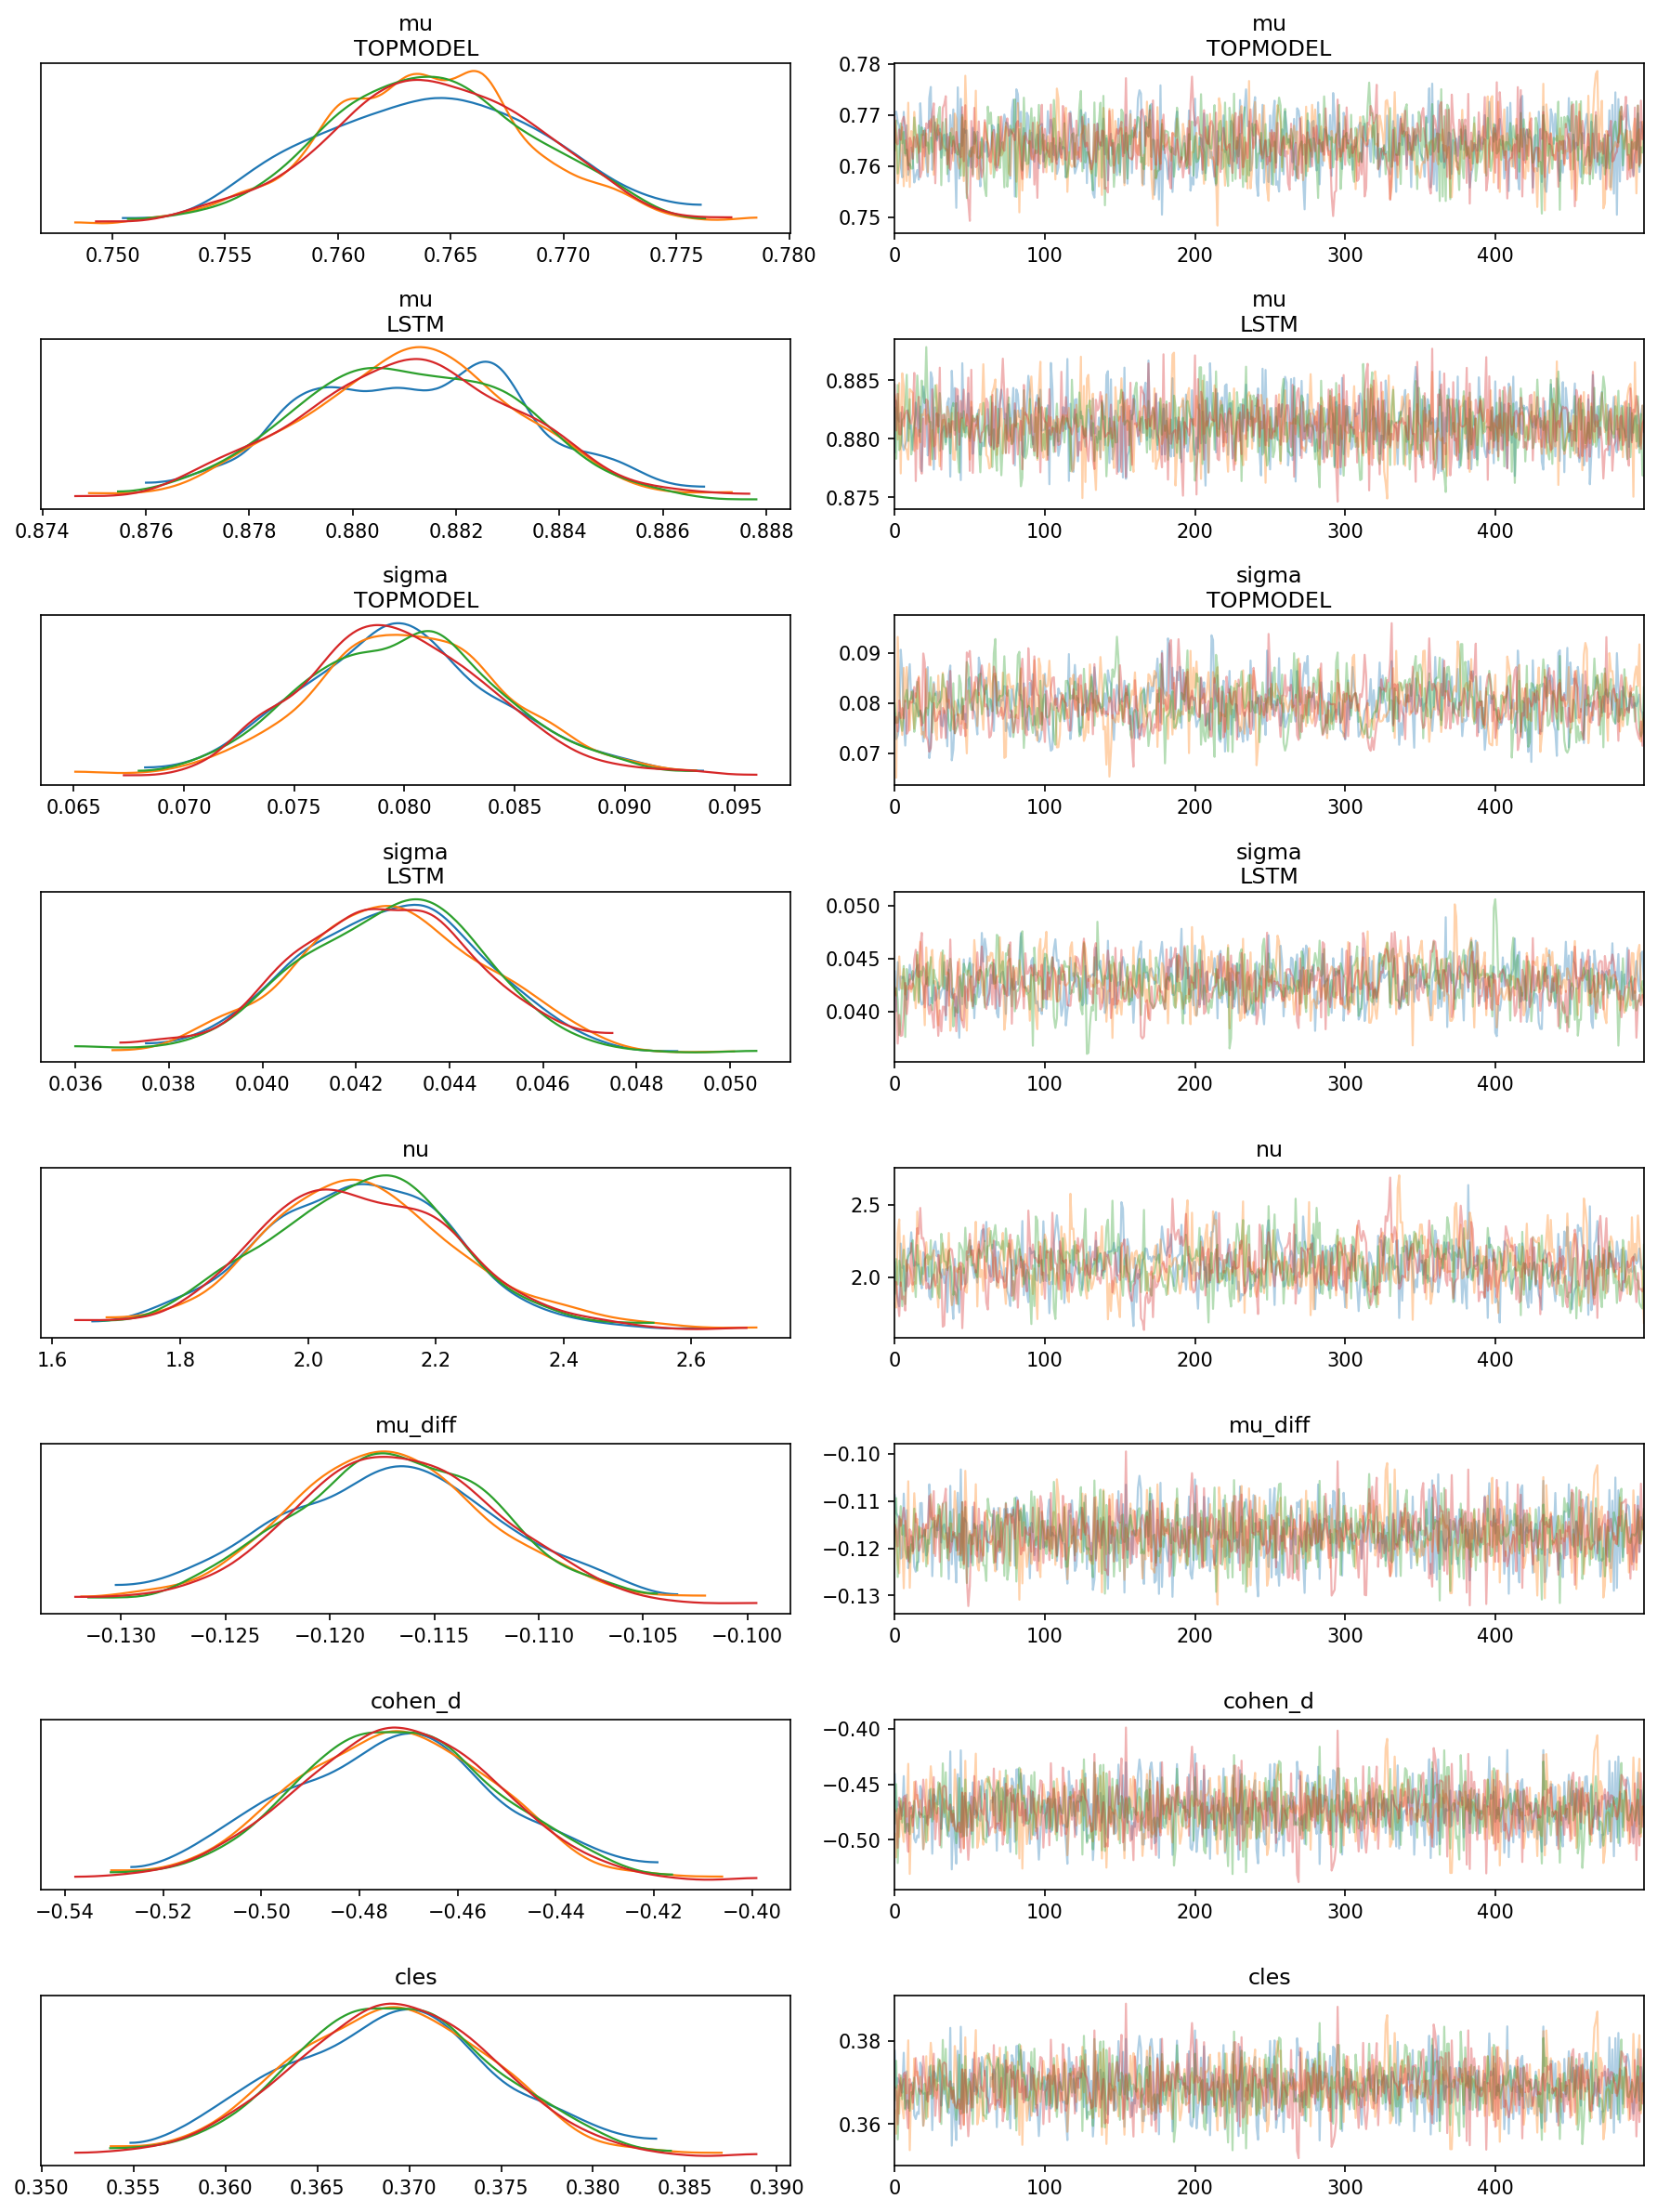

In [290]:
# print(dir(arviz))
data2 = arviz.from_pystan(
    posterior=other_fit, 
    dims={"mu": ["model"], "sigma": ["model"]}, 
    coords={"model": ["TOPMODEL", "LSTM"]}
)
post2 = data2.posterior.stack(sample=["chain", "draw"])
arviz.plot_trace(data2)
plt.tight_layout()
# data2.posterior

Plotting LSTM: 100%|██████████| 100/100 [00:02<00:00, 45.17it/s]


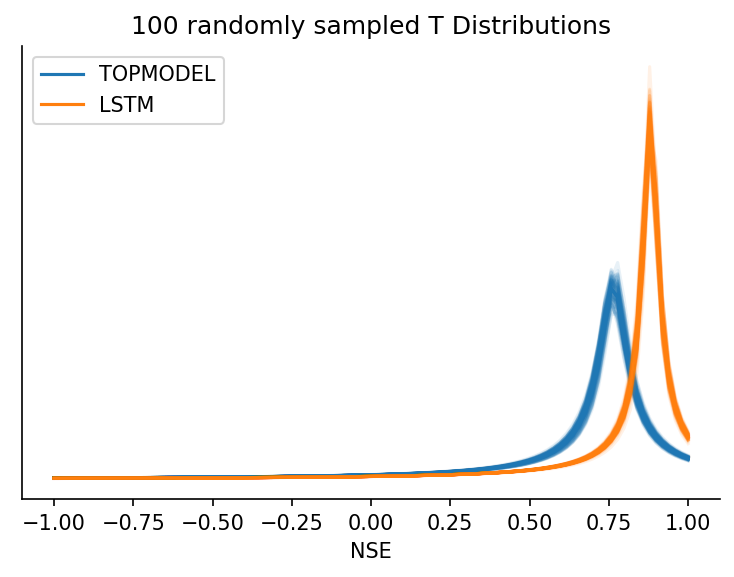

In [295]:
plot_sample_of_t_distributions(post2, N=100, nu_param="nu", mu_param="mu", sigma_param="sigma", exp_sigma=False)

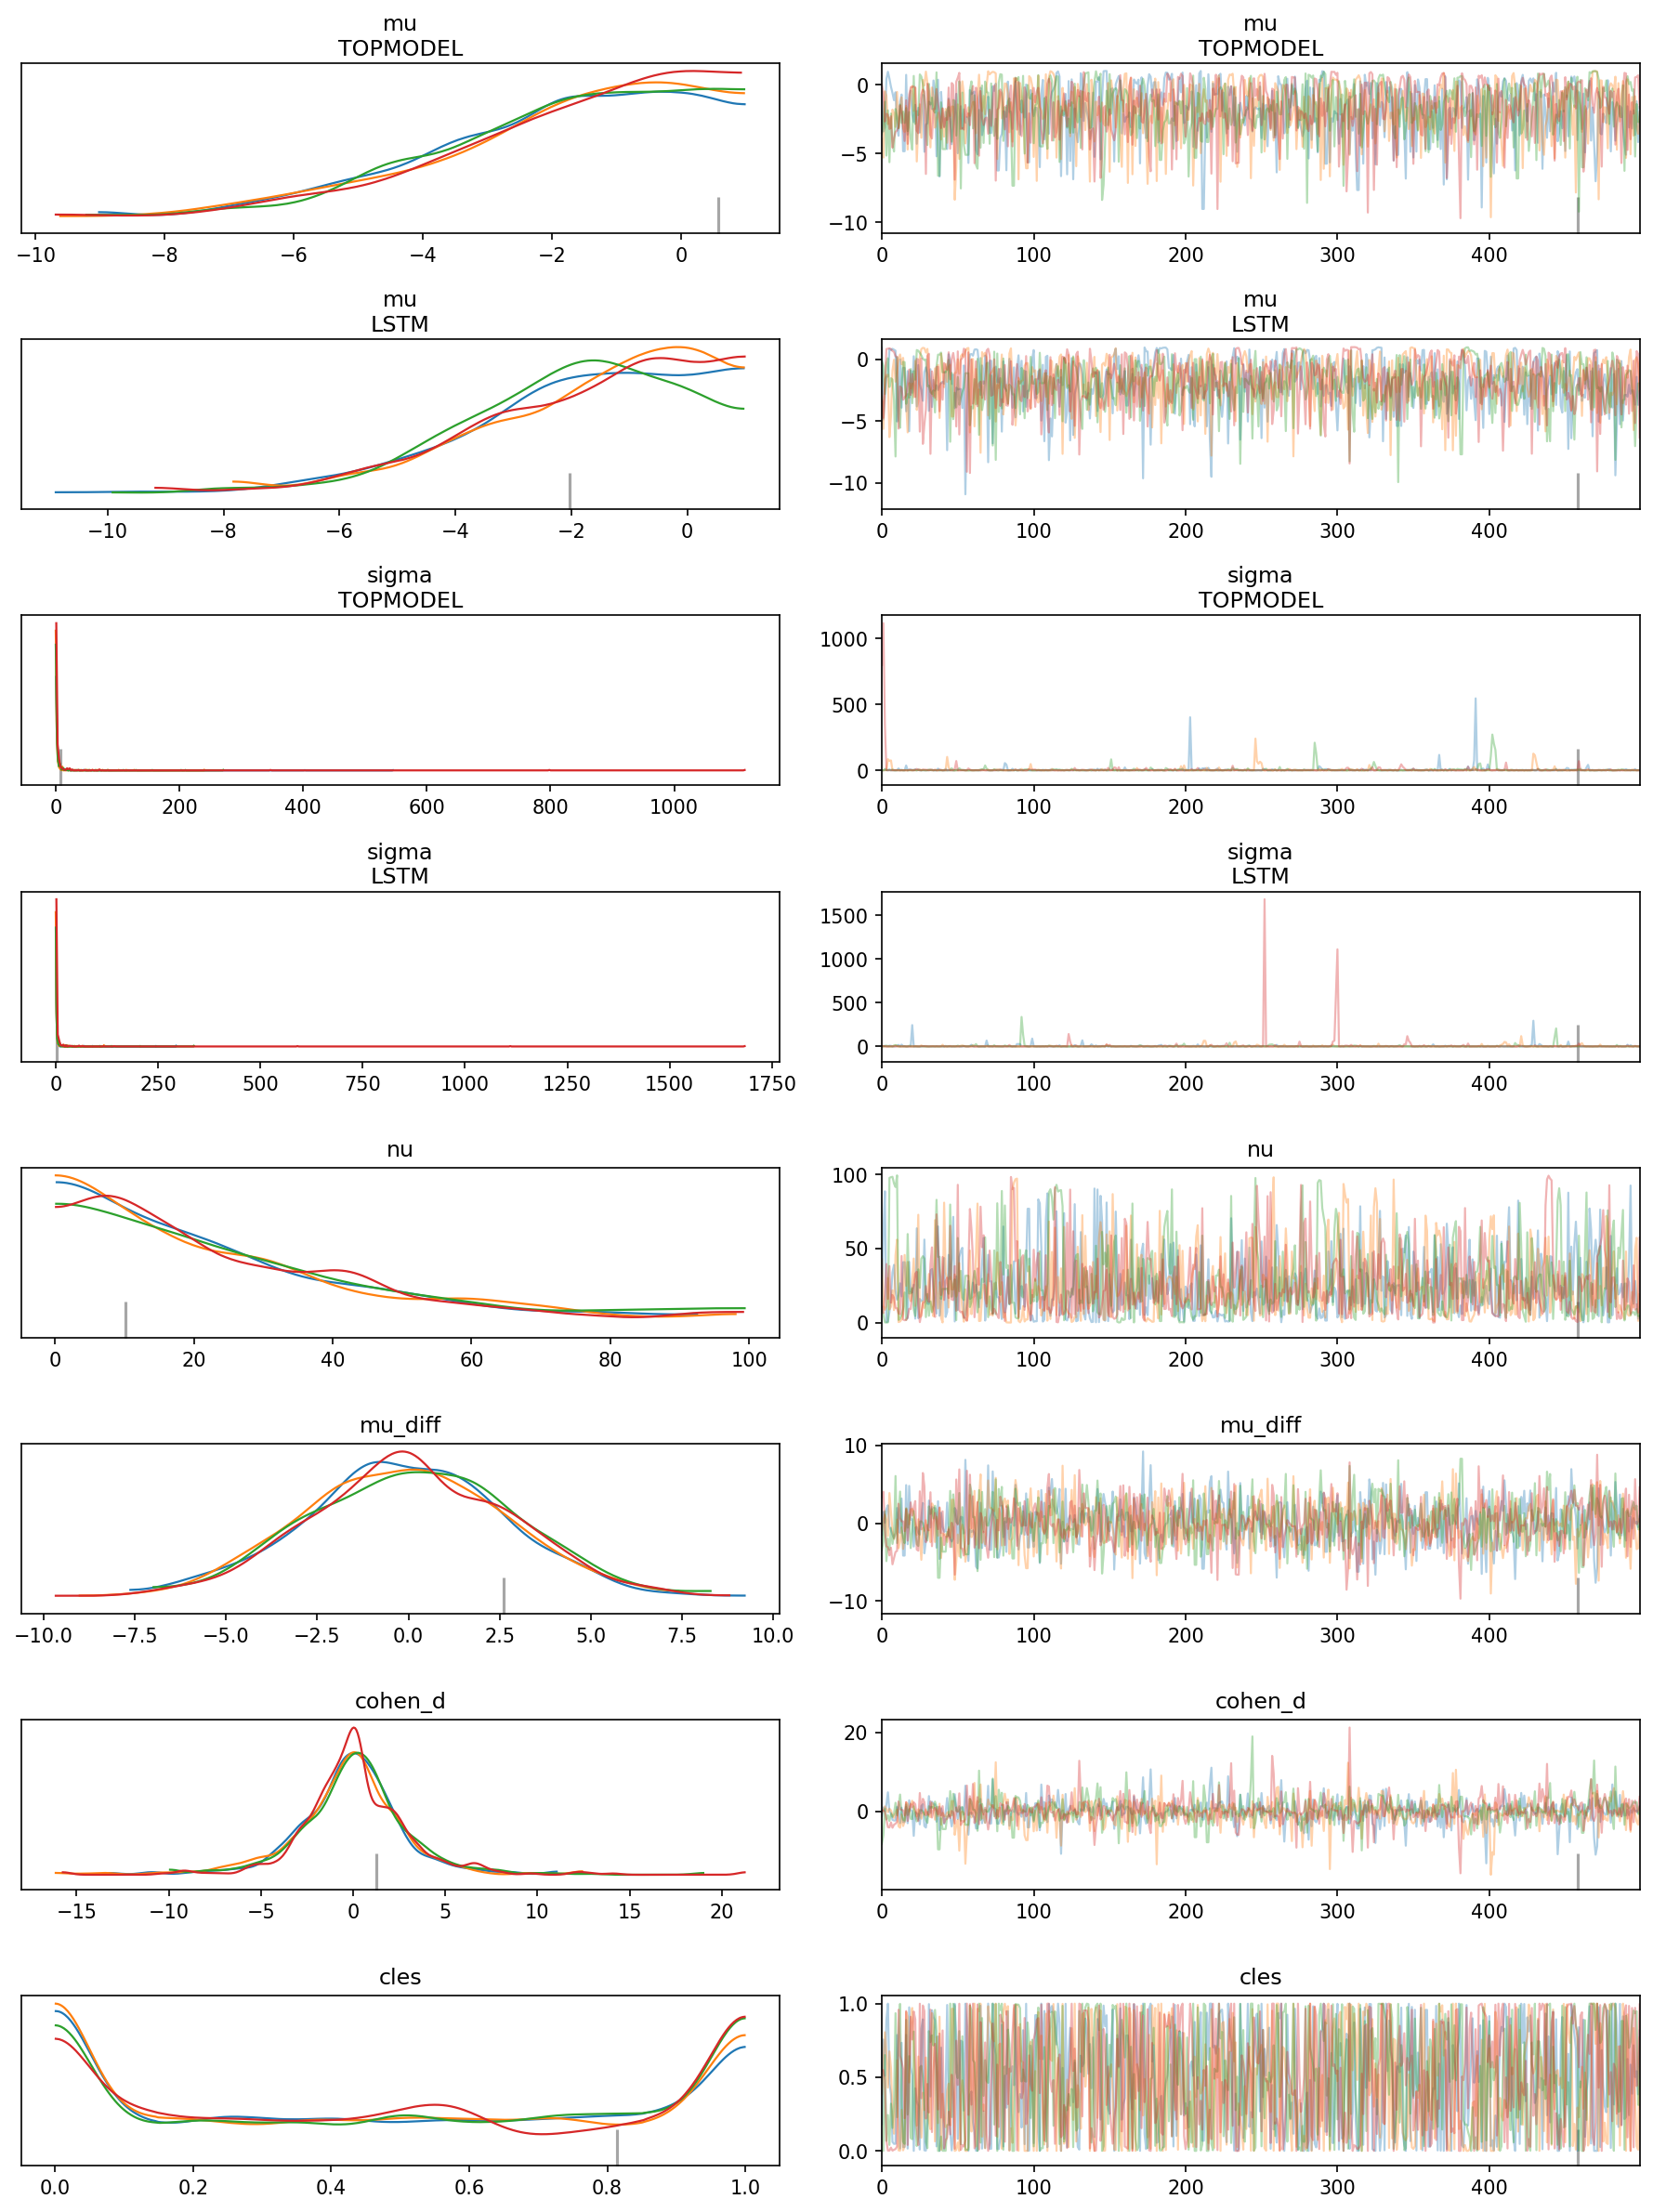

In [362]:
# print(dir(arviz))
prior_av = arviz.from_pystan(
    posterior=prior_fit, 
    dims={"mu": ["model"], "sigma": ["model"]}, 
    coords={"model": ["TOPMODEL", "LSTM"]}
)
prior2 = prior_av.posterior.stack(sample=["chain", "draw"])
arviz.plot_trace(prior_av)
plt.tight_layout()

Plotting LSTM: 100%|██████████| 100/100 [00:02<00:00, 44.52it/s]


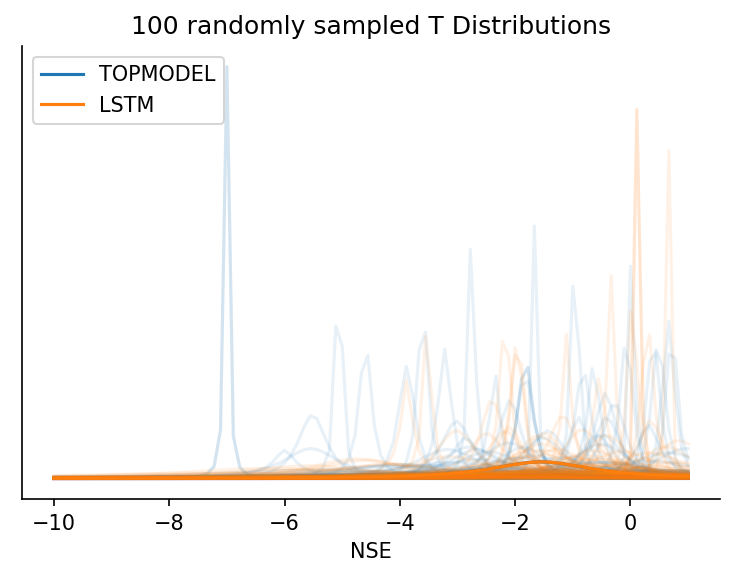

In [371]:
f, ax = plt.subplots()
xlim = (-10, 1)
ax = plot_sample_of_t_distributions(prior2, N=100, nu_param="nu", mu_param="mu", sigma_param="sigma", exp_sigma=False, ax=ax, xlim=xlim)

# Marginalia

In [283]:
# difference in means:
# https://bookdown.org/marklhc/notes_bookdown/group-comparisons.html
"""
data {
  int<lower=0> N1;            // number of observations (group 1)
  int<lower=0> N2;            // number of observations (group 2)
  vector[N1] y1;              // NSE scores (group 1);
  vector[N2] y2;              // NSE scores (group 2);
}
parameters {
  real<lower=0> mu_1;      // mean of group 1
  real beta;               // difference in means
  real lsigma_1;           // log of scale parameter for group 1
  real beta_lsigma;        // difference in log standard deviation
  real<lower=1> nu;        // degrees of freedom of student's t distribution
}
transformed parameters {
  real<lower=0> mu_2 = mu_1 + beta; 
  real<lower=0> sigma_1 = exp(lsigma_1);
  real<lower=0> sigma_2 = exp(lsigma_1 + beta_lsigma);
}
model {
  y1 ~ student_t(nu, mu_1, sigma_1);
  y2 ~ student_t(nu, mu_2, sigma_2);
  // prior
  mu_1 ~ normal(0.5, 2.5);
  beta ~ normal(0, 2.5);
  lsigma_1 ~ student_t(4, 0, 1);
  beta_lsigma ~ std_normal();
  nu ~ gamma(2, 0.1);
}
generated quantities {
  real sigma_ratio = sigma_2 / sigma_1;
  real y1rep[N1];
  real y2rep[N2];
  for (i in 1:N1) {
    y1rep[i] = student_t_rng(nu, mu_1, sigma_1);
  }
  for (i in 1:N2) {
    y2rep[i] = student_t_rng(nu, mu_2, sigma_2);
  }
}

"""


test_model = """
data{
    int<lower=1> N;  // number of observations
    vector[N] Y;  // response variable
}
parameters {
    real<upper=1> mu;      // mean
    real<lower=0> sigma;   // variance
    real<lower=1> nu;  // degrees of freedom or shape
}
model{
    # PRIORS
    nu ~ normal(1, 2)
    sigma ~ normal(0, 1)
    mu ~ normal(0, 4)

    # LIKELIHOOD
    Y ~ student_t(nu, mu, sigma);
}
"""